# Visualizing Barren Plateaus
[Sauce](https://github.com/Gopal-Dahale/ILearnQuantum/blob/main/layerwise_learning_with_qiskit_and_pytorch/barren_plateaus_visualization.ipynb)

In [1]:
# !pip install -q qiskit pylatexenc
# !pip install -q git+https://github.com/Gopal-Dahale/qiskit-qulacs.git

In [2]:
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.pyplot as plt
import numpy as np
from qiskit.circuit import Parameter
from qiskit.quantum_info import SparsePauliOp
from qiskit import QuantumCircuit
from qiskit_qulacs.qulacs_estimator import QulacsEstimator
import os
from qiskit.primitives import Estimator

seed = 42
np.random.seed(seed)

In [3]:
estimator = Estimator()

In [4]:
def generate_random_pqc(n_qubits, n_layers):

    qc = QuantumCircuit(n_qubits)

    theta, phi = Parameter('θ'), Parameter('φ')

    for q in range(n_qubits):
        qc.ry(np.pi / 4, q)

    qc.barrier()

    for l in range(n_layers):

        for q in range(n_qubits):

            if l == 0:
                val = theta
            elif l == 1:
                val = phi
            else:
                val = np.random.uniform(0, 2 * np.pi)

            num = np.random.randint(3)

            if l % 3 == 0:
                qc.rx(val, q)
            elif l % 3 == 1:
                qc.ry(val, q)
            else:
                qc.rz(val, q)

        for q in range(0, n_qubits - 1, 2):
            qc.cz(q, q + 1)
        for q in range(1, n_qubits - 1, 2):
            qc.cz(q, q + 1)

        qc.barrier()

    return qc

/home/ncng/.local/share/virtualenvs/VQA-Notes-v2-sVJD73WG/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


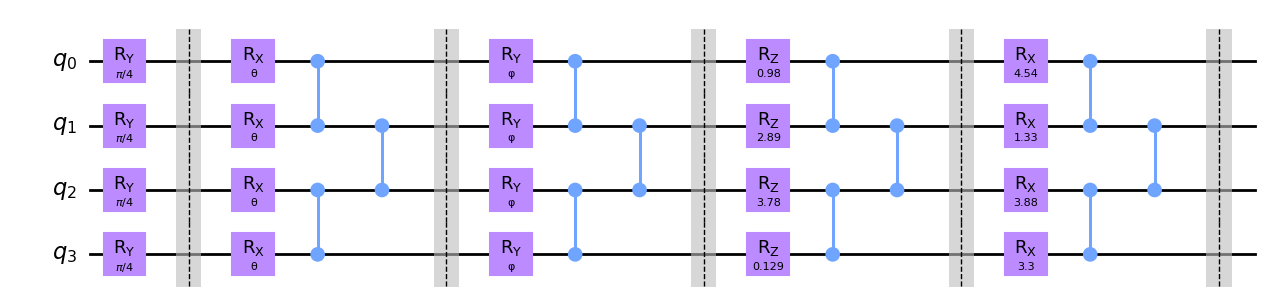

In [5]:
circ = generate_random_pqc(4, 4)
circ.draw('mpl')

In [6]:
def generate_surface(circuit, observable):
    Z = []
    Z_assembler = []

    X = np.arange(-np.pi, np.pi, 0.25)
    Y = np.arange(-np.pi, np.pi, 0.25)
    X, Y = np.meshgrid(X, Y)
    for x in X[0, :]:
        for y in Y[:, 0]:
            rotations = np.array([x, y])
            Z_assembler.append(
                estimator.run(circuit, observable,
                              rotations).result().values[0])
        Z.append(Z_assembler)
        Z_assembler = []

    Z = np.asarray(Z)
    return Z


def plot_surface(surface):
    X = np.arange(-np.pi, np.pi, 0.25)
    Y = np.arange(-np.pi, np.pi, 0.25)
    X, Y = np.meshgrid(X, Y)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    surf = ax.plot_surface(X,
                           Y,
                           surface,
                           rstride=1,
                           cstride=1,
                           cmap=plt.get_cmap('rainbow'),
                           linewidth=0,
                           antialiased=False,
                           alpha=0.6)
    ax.set_zlim(-1, 1)
    ax.set_xlabel('θ')
    ax.set_ylabel('φ')
    ax.set_zlabel('Pauli-Z Expectation')
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter("%.02f"))
    plt.show()

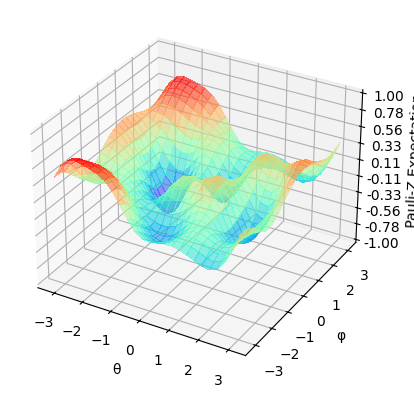

In [7]:
n_qubits = 4
n_layers = 50
op = SparsePauliOp(['I' * (n_qubits - 2) + 'ZZ'])

small_qubit_qc = generate_random_pqc(n_qubits, n_layers)

small_global_surface = generate_surface(small_qubit_qc, op)
plot_surface(small_global_surface)

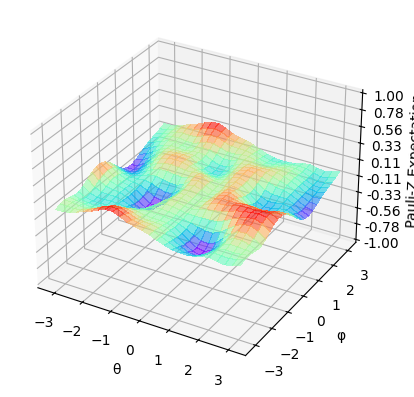

In [8]:
n_qubits = 12
n_layers = 50
op = SparsePauliOp(['I' * (n_qubits - 2) + 'ZZ'])

large_qubit_qc = generate_random_pqc(n_qubits, n_layers)

large_global_surface = generate_surface(large_qubit_qc, op)
plot_surface(large_global_surface)

In [9]:
# precede the number with zeros, creating a thong of a certain length
def makeIndexOfLength(index, length):
    indexStr = str(index)
    return ('0' * (length - len(indexStr)) + indexStr)

In [10]:
X = np.arange(-np.pi, np.pi, 0.25)
Y = np.arange(-np.pi, np.pi, 0.25)
X, Y = np.meshgrid(X, Y)

In [11]:
OUTPUT_DIR = "gradient_descent_small"
os.makedirs(OUTPUT_DIR, exist_ok=True)

for angle in range(0, 180):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection="3d")

    surf = ax.plot_surface(X,
                           Y,
                           small_global_surface,
                           rstride=1,
                           cstride=1,
                           cmap=plt.get_cmap('rainbow'),
                           linewidth=0,
                           antialiased=False,
                           alpha=0.6)

    ax.set_title("4 qubit, 50 layers circuit")
    ax.set_zlim(-1, 1)
    ax.set_xlabel('θ')
    ax.set_ylabel('φ')
    ax.set_zlabel('Pauli-Z Expectation')
    ax.view_init(30 + (90 - angle) / 5, 45 + angle * 2)
    plt.savefig("./" + OUTPUT_DIR + "/" + makeIndexOfLength(angle, 3) + ".png")
    plt.close()

In [14]:
OUTPUT_DIR = "gradient_descent_large"
os.makedirs(OUTPUT_DIR, exist_ok=True)

for angle in range(0, 180):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection="3d")

    surf = ax.plot_surface(X,
                           Y,
                           large_global_surface,
                           rstride=1,
                           cstride=1,
                           cmap=plt.get_cmap('rainbow'),
                           linewidth=0,
                           antialiased=False,
                           alpha=0.6)

    ax.set_title("12 qubit, 50 layers circuit")
    ax.set_zlim(-1, 1)
    ax.set_xlabel('θ')
    ax.set_ylabel('φ')
    ax.set_zlabel('Pauli-Z Expectation')
    ax.view_init(30 + (90 - angle) / 5, 45 + angle * 2)
    plt.savefig("./" + OUTPUT_DIR + "/" + makeIndexOfLength(angle, 3) + ".png")
    plt.close()